# AutoML for Images - Quality Control - Calling CV model

<img src="https://github.com/retkowsky/AutoMLforImages/blob/main/images/capturequalitycontrol.jpg?raw=true" width=700>

In [1]:
#!pip install librosa
#!pip install pymsteams
#!pip install emoji
#!pip install twilio
#!pip install azure-cognitiveservices-speech

In [2]:
import azureml.core
from azureml.core import Workspace, Dataset
from azureml.core.webservice import Webservice
import requests
import json
import matplotlib.pyplot as plt 
import cv2
import urllib
import time
from azure.cognitiveservices.speech import AudioDataStream, SpeechConfig, SpeechSynthesizer, SpeechSynthesisOutputFormat
from azure.cognitiveservices.speech.audio import AudioOutputConfig
import azure.cognitiveservices.speech as speechsdk
import librosa, librosa.display, IPython.display as ipd
from datetime import datetime
import pymsteams
import smtplib
from email.message import EmailMessage
import emoji

In [3]:
import datetime
dt = datetime.datetime.now()
today = dt.strftime("%Y-%m-%d %H:%M:%S")
print(today)

2021-12-14 17:34:49


In [4]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [6]:
ws = Workspace.from_config()

## Computer vision model to use

In [7]:
service = Webservice(workspace=ws, name='automlcv-qc')
#print(service.scoring_uri)
#print(service.swagger_uri)

In [8]:
primary, secondary = service.get_keys()

In [9]:
# URL for the web service
scoring_uri = service.scoring_uri
# If the service is authenticated, set the key or token
key = primary

## Image to analyze

In [10]:
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/CapTest1.jpg?raw=true'
#image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/CapTest2.jpg?raw=true'

imagefile = 'testqc.jpg'
urllib.request.urlretrieve(image_url, filename=imagefile)

('testqc.jpg', <http.client.HTTPMessage at 0x7f73de51c438>)

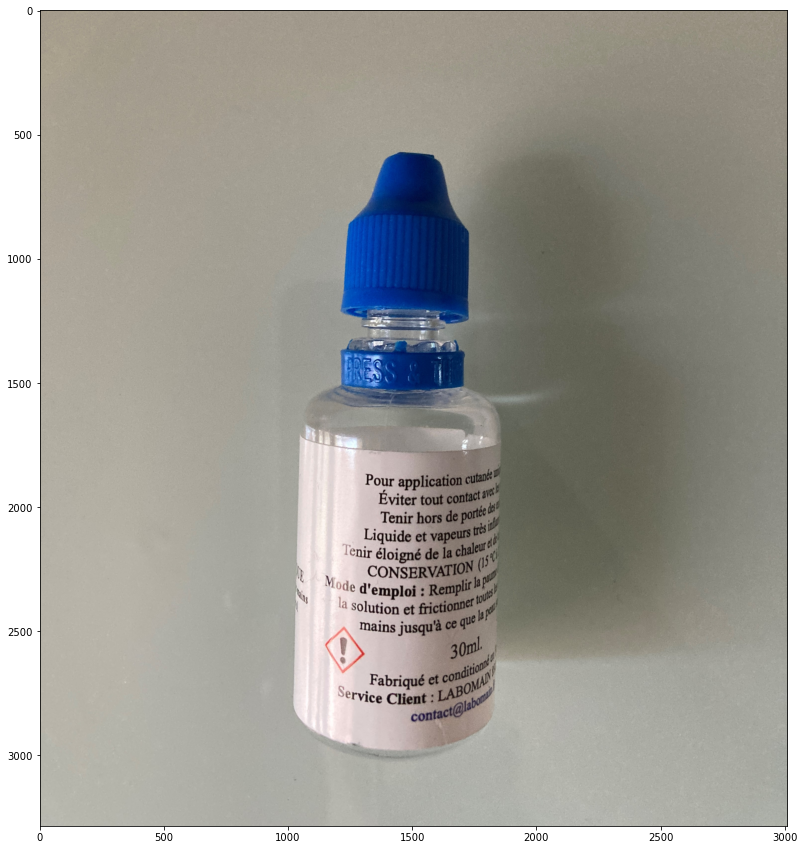

In [11]:
img = cv2.imread(imagefile)
h, w, c = img.shape
plt.figure(figsize=(15,15)) 
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [12]:
%%time
input_data = open(imagefile, 'rb').read()

# Set the content type
headers = {'Content-Type': 'application/json'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, input_data, headers=headers)
print(resp.text)

{"filename": "/tmp/tmp8fcsoty_", "boxes": [{"box": {"topX": 0.4032552152770371, "topY": 0.14219430685043336, "bottomX": 0.5788085729188887, "bottomY": 0.48699522018432617}, "label": "KO", "score": 0.7945041060447693}, {"box": {"topX": 0.4301152147937553, "topY": 0.19726017713546753, "bottomX": 0.5458810955998027, "bottomY": 0.4416024684906006}, "label": "KO", "score": 0.6721175909042358}]}

CPU times: user 6.89 ms, sys: 229 µs, total: 7.12 ms
Wall time: 522 ms


In [13]:
predictions = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in predictions['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    
predictions

{'filename': '/tmp/tmp8fcsoty_',
 'boxes': [{'box': {'topX': 0.4032552152770371,
    'topY': 0.14219430685043336,
    'bottomX': 0.5788085729188887,
    'bottomY': 0.48699522018432617},
   'label': 'KO',
   'score': 0.7945041060447693},
  {'box': {'topX': 0.4301152147937553,
    'topY': 0.19726017713546753,
    'bottomX': 0.5458810955998027,
    'bottomY': 0.4416024684906006},
   'label': 'KO',
   'score': 0.6721175909042358}]}

In [14]:
tag=predictions['boxes'][0]['label']
prob=predictions['boxes'][0]['score']
roi=predictions['boxes'][0]["box"]
topX=predictions['boxes'][0]["box"]['topX']
topY=predictions['boxes'][0]["box"]['topY']
bottomX=predictions['boxes'][0]["box"]['bottomX']
bottomY=predictions['boxes'][0]["box"]['bottomY']
lpheight=abs(topY-bottomY)

In [15]:
print('\033[1;31;34mPrediction:', tag, 'with prob =', round(prob, 4))
print()
print('\033[1;31;34mRegion:', roi)

Prediction: KO with prob = 0.7945

Region: {'topX': 0.4032552152770371, 'topY': 0.14219430685043336, 'bottomX': 0.5788085729188887, 'bottomY': 0.48699522018432617}


KO: [1213.395, 466.966, 528.24, 1132.326], 0.795
Prediction: not correct


<Figure size 1296x864 with 0 Axes>

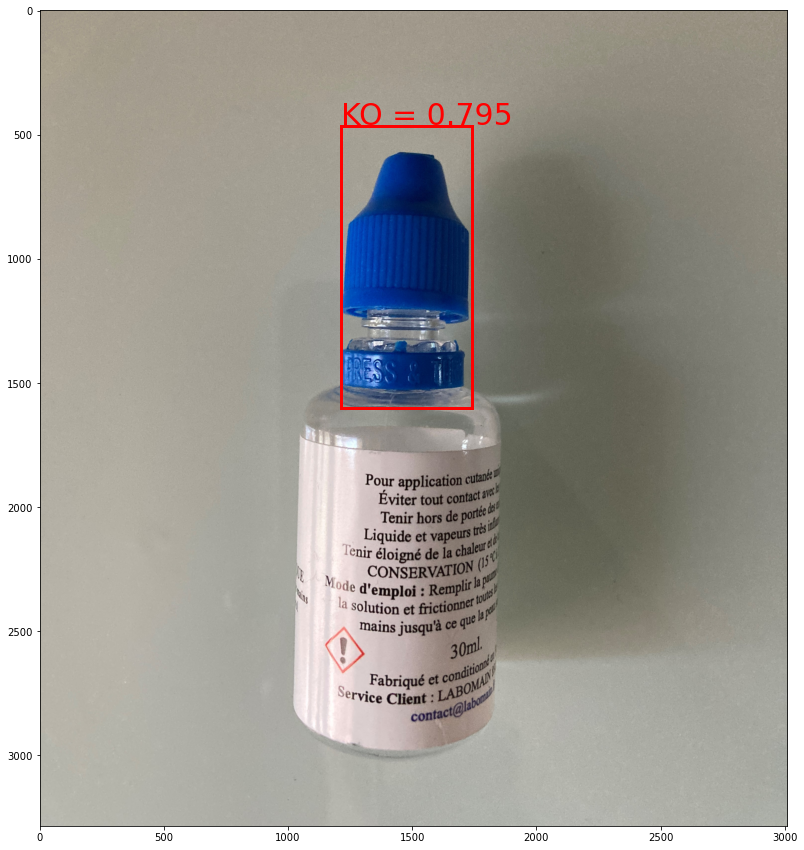

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(imagefile)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size
fig,ax = plt.subplots(1, figsize=(15,15)) #You can change the size

# Display the image
ax.imshow(img_np)

minscore=0.7

# draw box and label for each detection 
detections = json.loads(resp.text) # Loading the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    if conf_score >= minscore: #Min probability
        confidencescore = conf_score
        ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print('{}: [{}, {}, {}, {}], {}'.format(detect['label'], round(topleft_x, 3), 
                                                round(topleft_y, 3), round(width, 3), 
                                                round(height, 3), round(confidencescore, 3)))

        if label=="OK":
            color = "Green"
            speechlabel = "correct"
        if label=="KO":
            color="red"
            speechlabel = "not correct"
        
        rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                                 linewidth=3, edgecolor=color,facecolor='none')
        textdisp=label+' = '+str(round(conf_score, 3))
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, textdisp, color=color, fontsize=30)
        fig.savefig('resultQC.jpg', dpi=300) #Saving image
        print("Prediction:", speechlabel)
plt.show()

## Speech to Text

In [17]:
import configservices as configservices
azureSTT_key = configservices.azureSTT_key
azureSTT_region = configservices.azureSTT_region

In [18]:
LanguageToUse = 'EN'

audiofileqc = 'qc_' + LanguageToUse + '.wav'

if LanguageToUse == 'FR':
    MSG = "La prédiction contrôle qualité est " + str(speechlabel) + ' avec une confiance de '\
    + str(round(confidencescore, 2)*100) + '%'
    LANGUAGE = "fr-FR"
    
if LanguageToUse == 'EN':
    MSG = "The quality control prediction is " + str(speechlabel) + ' with a confidence of '\
    + str(round(confidencescore, 2)*100) + '%'
    LANGUAGE = "en-EN"

In [19]:
speech_config = SpeechConfig(subscription=azureSTT_key, region=azureSTT_region)
speech_config.speech_synthesis_language = LANGUAGE # Language to use

audio_config = AudioOutputConfig(filename=audiofileqc)
speech_synthesizer = speechsdk.SpeechSynthesizer(speech_config=speech_config)
synthesizer = SpeechSynthesizer(speech_config=speech_config, audio_config=audio_config,)

synthesizer.speak_text_async(MSG) # Text to Speech using the MSG text

print("========= Azure Text to Speech results =========\n")
from os.path import getsize
sizefile=getsize(audiofileqc)
print('File is:', audiofileqc)
print()
print(f"Size of '{audiofileqc}' file = {sizefile}")
print("Audio file date: %s" % time.ctime(os.path.getmtime(audiofileqc)))

samples, sampling_rate = librosa.load(audiofileqc, sr = None, mono = True, offset = 0.0, duration = None)
duration = len(samples) / sampling_rate
print("Audio file duration =", round(duration, 3), 'seconds')

========= Azure Text to Speech results =========

File is: qc_EN.wav

Size of 'qc_EN.wav' file = 173648
Audio file date: Tue Dec 14 17:35:45 2021
Audio file duration = 5.425 seconds


In [20]:
from IPython.display import Audio
Audio(audiofileqc)

## Sending results to TEAMS if the quality control prediction is not correct

In [21]:
import configservices as configservices
teams = configservices.teams

In [22]:
from datetime import datetime

if label == 'KO':
    now = datetime.now()
    TeamsMSG = '[' + str(now) + '] ' + MSG
    print('Message to send to Teams:\n', TeamsMSG)
    myTeamsMessage = pymsteams.connectorcard(teams)
    myTeamsMessage.text(TeamsMSG)
    #myTeamsMessage.printme()
    print("Sent message to Teams...")
    myTeamsMessage.send()
    print(emoji.emojize(':thumbs_up:'), 'Done')

Message to send to Teams:
 [2021-12-14 17:35:50.293605] The quality control prediction is not correct with a confidence of 79.0%
Sent message to Teams...
👍 Done


## Sending SMS

In [23]:
import configservices as configservices
twilio_account_sid = configservices.twilio_account_sid 
twilio_auth_token = configservices.twilio_auth_token 
twilio_source_phone_number = configservices.twilio_source_phone_number 

In [ ]:
if label == 'KO':
    # Sending the licence plate number by SMS
    from twilio.rest import Client

    print("Sending SMS...")

    client = Client(twilio_account_sid, twilio_auth_token)

    smstext = TeamsMSG
    print(smstext)

    message = client.messages.create(body=smstext, from_=twilio_source_phone_number, to="+tobereplaced")
    print(emoji.emojize(':thumbs_up:'), 'SMS sent!')

## Sending EMAIL

In [24]:
import configservices as configservices
EMAIL_SENDER = configservices.EMAIL_SENDER
EMAIL_PASSWORD = configservices.EMAIL_PASSWORD
EMAIL_RECEIVER = configservices.EMAIL_RECEIVER

In [25]:
if label == 'KO':
    import datetime
    emaildate = datetime.datetime.today().strftime ('%d-%b-%Y %H:%M:%S')

    msg = EmailMessage()

    msg['Subject'] = '[Alert] Quality Control issue detected at ' + str(emaildate)
    msg['From'] = EMAIL_SENDER 
    msg['To'] = EMAIL_RECEIVER 

    msg.set_content(MSG)

    attachedfile1 = 'resultQC.jpg'
    attachedfile2 = audiofileqc

    with open(attachedfile1, 'rb') as pdf:
        msg.add_attachment(pdf.read(), maintype='application', subtype='octet-stream', filename=pdf.name)

    with open(attachedfile2, 'rb') as pdf:
        msg.add_attachment(pdf.read(), maintype='application', subtype='octet-stream', filename=pdf.name)
    
    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
        print(emaildate, "Sending email...")
        smtp.login(EMAIL_SENDER, EMAIL_PASSWORD) 
        smtp.send_message(msg)
        print(emoji.emojize(':thumbs_up:'), 'Done.')

14-Dec-2021 17:35:58 Sending email...
👍 Done.


> End